In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

path = os.getcwd()
file_path = os.path.join(path,"file")
sub_path = os.path.join(path,"제출")
train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))
weights_path = os.path.join(path,"save_weights")
if not os.path.isdir(weights_path):
    os.mkdir(weights_path)

In [2]:
from pytimekr import pytimekr
import datetime

List_holiday = []
for i in range(5,1523,7):
    List_holiday.append((datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d"))
    
for i in range(2019,2024):
    List_holiday.extend(pytimekr.holidays(year=i)) #리스트 형태로 반환

for i in range(len(List_holiday)):
    List_holiday[i] = str(List_holiday[i])
np.sort(List_holiday)

array(['2019-01-01', '2019-01-06', '2019-01-13', '2019-01-20',
       '2019-01-27', '2019-02-03', '2019-02-04', '2019-02-05',
       '2019-02-06', '2019-02-10', '2019-02-17', '2019-02-24',
       '2019-03-01', '2019-03-03', '2019-03-10', '2019-03-17',
       '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-05',
       '2019-05-12', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-06', '2019-06-09', '2019-06-16',
       '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
       '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
       '2019-08-15', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-12', '2019-09-13', '2019-09-14',
       '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-03',
       '2019-10-06', '2019-10-09', '2019-10-13', '2019-10-20',
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
       '2019-11-24', '2019-12-01', '2019-12-08', '2019-

In [3]:
Holiday_y_n = []
for i in range(0,1523):
    if (datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d") in List_holiday:
        Holiday_y_n.append(0)
    else:
        Holiday_y_n.append(1)

In [4]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

In [5]:
a = test_df['ID'].str.split("_")
I = ""
J = ""
K = ""
List_Test = []
for i,j,k,l in a:
    if I!=i or J!=j or K!=k:
        List_Test.append([i,j,k])
        I = i
        J = j
        K = k
    else:
        continue

In [6]:
List_i_c_l = []
for i in train_df['item'].unique():
    for j in train_df['corporation'].unique():
        for k in train_df['location'].unique():
            if train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:].shape[0]!=0:
                List_i_c_l.append([i,j,k])

In [7]:
List_i_c_l

[['TG', 'A', 'J'],
 ['TG', 'A', 'S'],
 ['TG', 'B', 'J'],
 ['TG', 'B', 'S'],
 ['TG', 'C', 'J'],
 ['TG', 'C', 'S'],
 ['TG', 'D', 'J'],
 ['TG', 'D', 'S'],
 ['TG', 'E', 'J'],
 ['TG', 'E', 'S'],
 ['CR', 'A', 'J'],
 ['CR', 'B', 'J'],
 ['CR', 'C', 'J'],
 ['CR', 'D', 'J'],
 ['CR', 'D', 'S'],
 ['CR', 'E', 'J'],
 ['CR', 'E', 'S'],
 ['CB', 'A', 'J'],
 ['CB', 'A', 'S'],
 ['CB', 'D', 'J'],
 ['CB', 'E', 'J'],
 ['CB', 'F', 'J'],
 ['RD', 'A', 'J'],
 ['RD', 'A', 'S'],
 ['RD', 'C', 'S'],
 ['RD', 'D', 'J'],
 ['RD', 'D', 'S'],
 ['RD', 'E', 'J'],
 ['RD', 'E', 'S'],
 ['RD', 'F', 'J'],
 ['BC', 'A', 'J'],
 ['BC', 'A', 'S'],
 ['BC', 'B', 'J'],
 ['BC', 'B', 'S'],
 ['BC', 'C', 'J'],
 ['BC', 'C', 'S'],
 ['BC', 'D', 'J'],
 ['BC', 'E', 'J'],
 ['BC', 'E', 'S']]

In [8]:
for i, j, k in List_i_c_l:
    globals()[f"train_{i}_{j}_{k}"]=train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:]
    globals()[f"train_{i}_{j}_{k}"].drop(columns=['ID', 'timestamp', 'corporation','location'])
    globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
    globals()[f"train_{i}_{j}_{k}"] = globals()[f"train_{i}_{j}_{k}"][['supply(kg)', 'year', 'month', 'day','Holiday', 'price(원/kg)']]
    globals()[f"train_ar_{i}_{j}_{k}"] = np.array(globals()[f"train_{i}_{j}_{k}"])
#     print(i,j,k,globals()[f"train_{i}_{j}_{k}"].shape)
#     display(globals()[f"train_{i}_{j}_{k}"].corr())

C:\Users\USER\AppData\Local\Temp\ipykernel_25008\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_25008\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_25008\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [9]:
def minmaxscaler(data):
    s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))
    return s_data, np.min(data,axis=0), np.max(data,axis=0)

In [10]:
num = {"TG":10,"CR":7,"CB":5,"RD":8,"BC":9}
shape = globals()[f"train_ar_{i}_{j}_{k}"].shape
for i in train_df['item'].unique():
    globals()[f"train_x_concat_{i}"] = np.zeros((shape[0],num[i],shape[1]))
name = List_i_c_l[0][0]
n = 0
for i, j, k in List_i_c_l:
    if name != i :
        name=i
        n=0
    globals()[f"train_x_concat_{i}"][:,n,:] = globals()[f"train_ar_{i}_{j}_{k}"]
    n+=1
    globals()[f"train_minmax_{i}"],globals()[f"train_min_{i}"],globals()[f"train_max_{i}"] = minmaxscaler(globals()[f"train_x_concat_{i}"])

C:\Users\USER\AppData\Local\Temp\ipykernel_25008\313065710.py:2: RuntimeWarning: invalid value encountered in divide
  s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))


In [11]:
def build_dataset(Training_data, seq_length, future_length):
    dataX = []
    dataY = []
    for i in range(0, Training_data.shape[0]-seq_length-future_length+1): 
        _x = Training_data[i:i+seq_length,:,:]
        _y = Training_data[i+seq_length:i+seq_length+future_length,:,-1] 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [12]:
print(globals()[f"train_minmax_{i}"].shape)

(1523, 9, 6)


In [13]:
S_Length = 60
pred_Length = 28

for i in train_df['item'].unique():
    globals()[f"Train_x_{i}"], globals()[f"train_y_{i}"] = build_dataset(globals()[f"train_minmax_{i}"], S_Length, pred_Length)
    globals()[f"train_x_{i}"] = np.reshape(globals()[f"Train_x_{i}"],(globals()[f"Train_x_{i}"].shape[0],globals()[f"Train_x_{i}"].shape[1],-1))
    print(globals()[f"train_x_{i}"].shape, globals()[f"train_y_{i}"].shape)

(1436, 60, 60) (1436, 28, 10)
(1436, 60, 42) (1436, 28, 7)
(1436, 60, 30) (1436, 28, 5)
(1436, 60, 48) (1436, 28, 8)
(1436, 60, 54) (1436, 28, 9)


In [14]:
def rmse(y_true,y_pred):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.pow((y_true-y_pred),2)))

In [15]:
import tensorflow.keras.backend as K
def my_relu(x):
    return K.maximum(0.0, x)
def my_leaky_relu(x):
    alpha = 0.01
    return K.maximum(alpha*x, x)
def my_elu(x):
    # ELU 함수
    # alpha 값이 1외에 다른 값이면 SeLU가 된다.
    alpha = 1 
    return K.maximum(0., x) + K.maximum(0., -x) * (-1./(x+0.000001)) * alpha * (K.exp(x)-1)
for i in train_df['item'].unique():
    globals()[f"Model{i}"]=tf.keras.Sequential()
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=10, return_sequences = True, input_shape=(S_Length,globals()[f"train_x_{i}"].shape[2])))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=15,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(lambda x: x[:, -100:, :]))
    globals()[f"Model{i}"].add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(15)))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=15,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(lambda x: x[:, -28:, :]))
    globals()[f"Model{i}"].add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(15)))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=globals()[f"train_y_{i}"].shape[2],return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_relu))
    globals()[f"Model{i}"].compile(loss=rmse, optimizer=tf.keras.optimizers.Adam(lr=0.001))
    globals()[f"Model{i}"].summary()
    globals()[f"Model{i}"].fit(globals()[f"train_x_{i}"], globals()[f"train_y_{i}"], epochs=1000, batch_size=10)
    globals()[f"Model{i}"].save_weights(os.path.join(weights_path, i+"_weights"))

C:\Users\USER\anaconda3\envs\SU\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 10)            2840      
_________________________________________________________________
lambda (Lambda)              (None, 60, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 15)            1560      
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 15)            0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 60, 15)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 15)            240       
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 15)            1

144/144 [==============================] - 2s 12ms/step - loss: 0.1003
Epoch 75/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0995
Epoch 76/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1060
Epoch 77/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1024
Epoch 78/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1119
Epoch 79/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1076
Epoch 80/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1068
Epoch 81/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1050
Epoch 82/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1042
Epoch 83/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1039
Epoch 84/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1192
Epoch 85/1000
144/144 [==============================] - 2s 13ms/step - loss: 0

144/144 [==============================] - 2s 13ms/step - loss: 0.0798
Epoch 170/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0788
Epoch 171/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1881
Epoch 172/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1645
Epoch 173/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1528
Epoch 174/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1466
Epoch 175/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1433
Epoch 176/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1404
Epoch 177/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1383
Epoch 178/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1374
Epoch 179/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1367
Epoch 180/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.1418
Epoch 265/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1415
Epoch 266/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1410
Epoch 267/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1408
Epoch 268/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1403
Epoch 269/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1399
Epoch 270/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1392
Epoch 271/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1389
Epoch 272/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1386
Epoch 273/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1382
Epoch 274/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1377
Epoch 275/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.1173
Epoch 360/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1167
Epoch 361/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1164
Epoch 362/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1162
Epoch 363/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1155
Epoch 364/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1156
Epoch 365/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1153
Epoch 366/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1160
Epoch 367/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1160
Epoch 368/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1146
Epoch 369/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1147
Epoch 370/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.1064
Epoch 455/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1053
Epoch 456/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1048
Epoch 457/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1062
Epoch 458/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1047
Epoch 459/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1034
Epoch 460/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1031
Epoch 461/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1034
Epoch 462/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1028
Epoch 463/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1017
Epoch 464/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1264
Epoch 465/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.1117
Epoch 550/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1322
Epoch 551/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1287
Epoch 552/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1203
Epoch 553/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1161
Epoch 554/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1136
Epoch 555/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1122
Epoch 556/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1112
Epoch 557/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1106
Epoch 558/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1101
Epoch 559/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1094
Epoch 560/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.1271
Epoch 645/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1248
Epoch 646/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1257
Epoch 647/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1223
Epoch 648/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1202
Epoch 649/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1181
Epoch 650/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1162
Epoch 651/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1151
Epoch 652/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1134
Epoch 653/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1127
Epoch 654/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1114
Epoch 655/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.1082
Epoch 740/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1070
Epoch 741/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1064
Epoch 742/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1061
Epoch 743/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1086
Epoch 744/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1203
Epoch 745/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1420
Epoch 746/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1278
Epoch 747/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1209
Epoch 748/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1174
Epoch 749/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1118
Epoch 750/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.1517
Epoch 835/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1484
Epoch 836/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1457
Epoch 837/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1438
Epoch 838/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1422
Epoch 839/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1405
Epoch 840/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1398
Epoch 841/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1385
Epoch 842/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1373
Epoch 843/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1362
Epoch 844/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1352
Epoch 845/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0982
Epoch 930/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0969
Epoch 931/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1024
Epoch 932/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0993
Epoch 933/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0961
Epoch 934/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0967
Epoch 935/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0955
Epoch 936/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0983
Epoch 937/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0952
Epoch 938/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0943
Epoch 939/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1292
Epoch 940/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 7s 15ms/step - loss: 0.1614
Epoch 2/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1467
Epoch 3/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1409
Epoch 4/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1495
Epoch 5/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1390
Epoch 6/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1338
Epoch 7/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1319
Epoch 8/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1285
Epoch 9/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1275
Epoch 10/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1262
Epoch 11/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1441
Epoch 12/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1603
Ep

144/144 [==============================] - 2s 14ms/step - loss: 0.0564
Epoch 98/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0576
Epoch 99/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0555
Epoch 100/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0573
Epoch 101/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0557
Epoch 102/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0542
Epoch 103/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0791
Epoch 104/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0587
Epoch 105/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0537
Epoch 106/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0580
Epoch 107/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0534
Epoch 108/1000
144/144 [==============================] - 2s 14ms/step 

144/144 [==============================] - 2s 13ms/step - loss: 0.0998
Epoch 193/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1161
Epoch 194/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0992
Epoch 195/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0920
Epoch 196/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0869
Epoch 197/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0822
Epoch 198/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0801
Epoch 199/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0793
Epoch 200/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0875
Epoch 201/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0789
Epoch 202/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0758
Epoch 203/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0460
Epoch 288/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0472
Epoch 289/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0458
Epoch 290/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0476
Epoch 291/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0459
Epoch 292/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0445
Epoch 293/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0450
Epoch 294/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0473
Epoch 295/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0642
Epoch 296/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0467
Epoch 297/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0433
Epoch 298/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0828
Epoch 383/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0737
Epoch 384/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0681
Epoch 385/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0667
Epoch 386/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0636
Epoch 387/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0605
Epoch 388/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0591
Epoch 389/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0576
Epoch 390/1000
144/144 [==============================] - 2s 15ms/step - loss: 0.0565
Epoch 391/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0552
Epoch 392/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0549
Epoch 393/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0432
Epoch 478/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0509
Epoch 479/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0463
Epoch 480/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0527
Epoch 481/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0497
Epoch 482/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1069
Epoch 483/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1341
Epoch 484/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1304
Epoch 485/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1248
Epoch 486/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1210
Epoch 487/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1190
Epoch 488/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0577
Epoch 573/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0574
Epoch 574/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0569
Epoch 575/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0567
Epoch 576/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0562
Epoch 577/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0565
Epoch 578/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0558
Epoch 579/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0552
Epoch 580/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0748
Epoch 581/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0753
Epoch 582/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0695
Epoch 583/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0724
Epoch 668/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0719
Epoch 669/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0715
Epoch 670/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0709
Epoch 671/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0700
Epoch 672/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0709
Epoch 673/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0725
Epoch 674/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0751
Epoch 675/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0692
Epoch 676/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0689
Epoch 677/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0706
Epoch 678/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 11ms/step - loss: 0.0524
Epoch 763/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0518
Epoch 764/1000
144/144 [==============================] - 1s 8ms/step - loss: 0.0520
Epoch 765/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0527
Epoch 766/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0514
Epoch 767/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0576
Epoch 768/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0540
Epoch 769/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0522
Epoch 770/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0515
Epoch 771/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0512
Epoch 772/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0528
Epoch 773/1000
144/144 [==============================] - 2s 12ms/step

144/144 [==============================] - 2s 12ms/step - loss: 0.1344
Epoch 858/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1329
Epoch 859/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1319
Epoch 860/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1336
Epoch 861/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1334
Epoch 862/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1313
Epoch 863/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1309
Epoch 864/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1309
Epoch 865/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1296
Epoch 866/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1285
Epoch 867/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1275
Epoch 868/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.1861
Epoch 953/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1821
Epoch 954/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1799
Epoch 955/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1773
Epoch 956/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1737
Epoch 957/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1698
Epoch 958/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1677
Epoch 959/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1653
Epoch 960/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1646
Epoch 961/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1634
Epoch 962/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1621
Epoch 963/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.1038
Epoch 26/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1031
Epoch 27/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1016
Epoch 28/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1012
Epoch 29/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1006
Epoch 30/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1003
Epoch 31/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1019
Epoch 32/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0996
Epoch 33/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0994
Epoch 34/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0997
Epoch 35/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0977
Epoch 36/1000
144/144 [==============================] - 2s 14ms/step - loss: 0

144/144 [==============================] - 2s 11ms/step - loss: 0.0545
Epoch 122/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0547
Epoch 123/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0538
Epoch 124/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0535
Epoch 125/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0536
Epoch 126/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0520
Epoch 127/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0539
Epoch 128/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0518
Epoch 129/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0516
Epoch 130/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0517
Epoch 131/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0526
Epoch 132/1000
144/144 [==============================] - 2s 11ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0858
Epoch 217/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0855
Epoch 218/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0846
Epoch 219/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0836
Epoch 220/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0824
Epoch 221/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0828
Epoch 222/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0814
Epoch 223/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0815
Epoch 224/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0805
Epoch 225/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0809
Epoch 226/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0804
Epoch 227/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 1s 9ms/step - loss: 0.0558
Epoch 312/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0520
Epoch 313/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0480
Epoch 314/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0477
Epoch 315/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0482
Epoch 316/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0491
Epoch 317/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0461
Epoch 318/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0457
Epoch 319/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0454
Epoch 320/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0451
Epoch 321/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0491
Epoch 322/1000
144/144 [==============================] - 2s 12ms/step

144/144 [==============================] - 1s 10ms/step - loss: 0.1414
Epoch 407/1000
144/144 [==============================] - 1s 9ms/step - loss: 0.1311
Epoch 408/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1257
Epoch 409/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1219
Epoch 410/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1170
Epoch 411/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1129
Epoch 412/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1089
Epoch 413/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1061
Epoch 414/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1036
Epoch 415/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1013
Epoch 416/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0997
Epoch 417/1000
144/144 [==============================] - 2s 11ms/step

144/144 [==============================] - 2s 13ms/step - loss: 0.0691
Epoch 502/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0707
Epoch 503/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0696
Epoch 504/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0704
Epoch 505/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0680
Epoch 506/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0686
Epoch 507/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0813
Epoch 508/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0762
Epoch 509/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0729
Epoch 510/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0704
Epoch 511/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0691
Epoch 512/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 11ms/step - loss: 0.0814
Epoch 597/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0804
Epoch 598/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0784
Epoch 599/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0784
Epoch 600/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0769
Epoch 601/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0758
Epoch 602/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0748
Epoch 603/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0742
Epoch 604/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0725
Epoch 605/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0719
Epoch 606/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0716
Epoch 607/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0830
Epoch 692/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0780
Epoch 693/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0750
Epoch 694/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0722
Epoch 695/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0704
Epoch 696/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0690
Epoch 697/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0681
Epoch 698/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0663
Epoch 699/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0648
Epoch 700/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0631
Epoch 701/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0633
Epoch 702/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 11ms/step - loss: 0.1201
Epoch 787/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1192
Epoch 788/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1202
Epoch 789/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1172
Epoch 790/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1163
Epoch 791/1000
144/144 [==============================] - 1s 9ms/step - loss: 0.1152
Epoch 792/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1151
Epoch 793/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.1135
Epoch 794/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1148
Epoch 795/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1128
Epoch 796/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1115
Epoch 797/1000
144/144 [==============================] - 2s 13ms/step

144/144 [==============================] - 2s 13ms/step - loss: 0.0949
Epoch 882/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0937
Epoch 883/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0936
Epoch 884/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0938
Epoch 885/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0933
Epoch 886/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0934
Epoch 887/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0926
Epoch 888/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0916
Epoch 889/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0917
Epoch 890/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0914
Epoch 891/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0909
Epoch 892/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0744
Epoch 977/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0745
Epoch 978/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0765
Epoch 979/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0730
Epoch 980/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0732
Epoch 981/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0728
Epoch 982/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0720
Epoch 983/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0709
Epoch 984/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0713
Epoch 985/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0707
Epoch 986/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1048
Epoch 987/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0872
Epoch 50/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0852
Epoch 51/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0919
Epoch 52/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0835
Epoch 53/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0822
Epoch 54/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0811
Epoch 55/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0806
Epoch 56/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0810
Epoch 57/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0810
Epoch 58/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0795
Epoch 59/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0791
Epoch 60/1000
144/144 [==============================] - 2s 13ms/step - loss: 0

144/144 [==============================] - 2s 11ms/step - loss: 0.0611
Epoch 146/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0596
Epoch 147/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0607
Epoch 148/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0614
Epoch 149/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0713
Epoch 150/1000
144/144 [==============================] - 1s 9ms/step - loss: 0.0716
Epoch 151/1000
144/144 [==============================] - 1s 9ms/step - loss: 0.0610
Epoch 152/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0599
Epoch 153/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0586
Epoch 154/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0588
Epoch 155/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0587
Epoch 156/1000
144/144 [==============================] - 2s 11ms/step 

144/144 [==============================] - 1s 10ms/step - loss: 0.0594
Epoch 241/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0592
Epoch 242/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0599
Epoch 243/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0600
Epoch 244/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0793
Epoch 245/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0788
Epoch 246/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0613
Epoch 247/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0593
Epoch 248/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0583
Epoch 249/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0580
Epoch 250/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0574
Epoch 251/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0682
Epoch 336/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0622
Epoch 337/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0591
Epoch 338/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0558
Epoch 339/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0531
Epoch 340/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0519
Epoch 341/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0513
Epoch 342/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0512
Epoch 343/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0509
Epoch 344/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0569
Epoch 345/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0591
Epoch 346/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 1s 10ms/step - loss: 0.0567
Epoch 431/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0538
Epoch 432/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0527
Epoch 433/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0513
Epoch 434/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0510
Epoch 435/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0496
Epoch 436/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0495
Epoch 437/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0512
Epoch 438/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0809
Epoch 439/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0596
Epoch 440/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0514
Epoch 441/1000
144/144 [==============================] - 2s 10ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0664
Epoch 526/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0623
Epoch 527/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0581
Epoch 528/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0575
Epoch 529/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0529
Epoch 530/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0519
Epoch 531/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0504
Epoch 532/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0504
Epoch 533/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0492
Epoch 534/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0505
Epoch 535/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0488
Epoch 536/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 11ms/step - loss: 0.0769
Epoch 621/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0788
Epoch 622/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0736
Epoch 623/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0723
Epoch 624/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0713
Epoch 625/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0695
Epoch 626/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0702
Epoch 627/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0726
Epoch 628/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0687
Epoch 629/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0675
Epoch 630/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0736
Epoch 631/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0523
Epoch 716/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0520
Epoch 717/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0516
Epoch 718/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0546
Epoch 719/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0514
Epoch 720/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0509
Epoch 721/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0510
Epoch 722/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0956
Epoch 723/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1419
Epoch 724/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1322
Epoch 725/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1254
Epoch 726/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0987
Epoch 811/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0982
Epoch 812/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0983
Epoch 813/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0972
Epoch 814/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0967
Epoch 815/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0961
Epoch 816/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0951
Epoch 817/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0949
Epoch 818/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0938
Epoch 819/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0935
Epoch 820/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0929
Epoch 821/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0921
Epoch 906/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0925
Epoch 907/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0935
Epoch 908/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0917
Epoch 909/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1085
Epoch 910/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0998
Epoch 911/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0970
Epoch 912/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0949
Epoch 913/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0932
Epoch 914/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0922
Epoch 915/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0915
Epoch 916/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 11ms/step - loss: 0.1037
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 60, 10)            2600      
_________________________________________________________________
lambda_24 (Lambda)           (None, 60, 10)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 60, 15)            1560      
_________________________________________________________________
lambda_25 (Lambda)           (None, 60, 15)            0         
_________________________________________________________________
lambda_26 (Lambda)           (None, 60, 15)            0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 60, 15)            240       
_________________________________________________

144/144 [==============================] - 2s 13ms/step - loss: 0.0777
Epoch 74/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0782
Epoch 75/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0766
Epoch 76/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0766
Epoch 77/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0763
Epoch 78/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0758
Epoch 79/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.0749
Epoch 80/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0759
Epoch 81/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0748
Epoch 82/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0756
Epoch 83/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0729
Epoch 84/1000
144/144 [==============================] - 2s 14ms/step - loss: 0

144/144 [==============================] - 2s 12ms/step - loss: 0.0547
Epoch 169/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0545
Epoch 170/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0536
Epoch 171/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0541
Epoch 172/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0534
Epoch 173/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0544
Epoch 174/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0541
Epoch 175/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0535
Epoch 176/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0531
Epoch 177/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0531
Epoch 178/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0536
Epoch 179/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0499
Epoch 264/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0492
Epoch 265/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0502
Epoch 266/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0491
Epoch 267/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0491
Epoch 268/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0495
Epoch 269/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0672
Epoch 270/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0490
Epoch 271/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0492
Epoch 272/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0505
Epoch 273/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0481
Epoch 274/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0444
Epoch 359/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0450
Epoch 360/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0466
Epoch 361/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0445
Epoch 362/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0436
Epoch 363/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0437
Epoch 364/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0439
Epoch 365/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0435
Epoch 366/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0437
Epoch 367/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0441
Epoch 368/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0431
Epoch 369/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 14ms/step - loss: 0.0699
Epoch 454/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0698
Epoch 455/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0697
Epoch 456/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0706
Epoch 457/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0832
Epoch 458/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1572
Epoch 459/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1301
Epoch 460/1000
144/144 [==============================] - 1s 10ms/step - loss: 0.1168
Epoch 461/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1122
Epoch 462/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1077
Epoch 463/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1043
Epoch 464/1000
144/144 [==============================] - 2s 11ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0691
Epoch 549/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0694
Epoch 550/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0702
Epoch 551/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0690
Epoch 552/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0693
Epoch 553/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0686
Epoch 554/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0685
Epoch 555/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0694
Epoch 556/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0718
Epoch 557/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0794
Epoch 558/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0686
Epoch 559/1000
144/144 [==============================] - 2s 14ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.0605
Epoch 644/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0601
Epoch 645/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0608
Epoch 646/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0618
Epoch 647/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0609
Epoch 648/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.0600
Epoch 649/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0610
Epoch 650/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0618
Epoch 651/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0591
Epoch 652/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0633
Epoch 653/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1805
Epoch 654/1000
144/144 [==============================] - 2s 12ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.1204
Epoch 739/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1177
Epoch 740/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1160
Epoch 741/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1153
Epoch 742/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1147
Epoch 743/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1150
Epoch 744/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1146
Epoch 745/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1132
Epoch 746/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1242
Epoch 747/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1294
Epoch 748/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1262
Epoch 749/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 13ms/step - loss: 0.1238
Epoch 834/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1178
Epoch 835/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.1157
Epoch 836/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1132
Epoch 837/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1118
Epoch 838/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1102
Epoch 839/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.1097
Epoch 840/1000
144/144 [==============================] - 2s 11ms/step - loss: 0.1080
Epoch 841/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1072
Epoch 842/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1059
Epoch 843/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.1167
Epoch 844/1000
144/144 [==============================] - 2s 13ms/ste

144/144 [==============================] - 2s 12ms/step - loss: 0.0990
Epoch 929/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0981
Epoch 930/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0982
Epoch 931/1000
144/144 [==============================] - 2s 12ms/step - loss: 0.0975
Epoch 932/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0972
Epoch 933/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0970
Epoch 934/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0965
Epoch 935/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0958
Epoch 936/1000
144/144 [==============================] - 2s 13ms/step - loss: 0.0961
Epoch 937/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0950
Epoch 938/1000
144/144 [==============================] - 2s 14ms/step - loss: 0.0952
Epoch 939/1000
144/144 [==============================] - 2s 13ms/ste

In [16]:
preds = np.zeros((0,1))
for i in train_df['item'].unique():
    print(i)
    predict = np.reshape(globals()[f"train_minmax_{i}"][-S_Length:,:,:],(1,S_Length,-1))
    globals()[f"Model{i}"].load_weights(os.path.join(weights_path, i+"_weights"))
    globals()[f"Predict{i}"] = globals()[f"Model{i}"].predict(predict)
    globals()[f"Predict_re{i}"] = (globals()[f"Predict{i}"]*(globals()[f"train_max_{i}"][:,-1] - globals()[f"train_min_{i}"][:,-1]) + globals()[f"train_min_{i}"][:,-1])[0]
    print(globals()[f"Predict_re{i}"].shape)
    globals()[f"Predict_Re{i}"] = np.reshape(np.transpose(globals()[f"Predict_re{i}"]),-1)
    globals()[f"Predict_Re{i}"][np.where((globals()[f"Predict_Re{i}"]<=0))[0]] = 0
    preds = np.vstack((preds,np.expand_dims(globals()[f"Predict_Re{i}"],axis = -1)))
    print(globals()[f"Predict_Re{i}"].shape)

TG
(28, 10)
(280,)
CR
(28, 7)
(196,)
CB
(28, 5)
(140,)
RD
(28, 8)
(224,)
BC
(28, 9)
(252,)


In [17]:
submission = pd.read_csv(os.path.join(file_path,"sample_submission.csv"))
submission


,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [18]:
holiday_test = ["20230305","20230312","20230319","20230326"]
submission['answer'] = preds
submission.loc[submission['ID'].str.split("_").str[3].isin(holiday_test),"answer"] = 0
display(submission.head(20))
display(submission.tail(20))

,ID,answer
0,TG_A_J_20230304,2860.656182
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3301.131148
3,TG_A_J_20230307,2597.211791
4,TG_A_J_20230308,3751.909679
5,TG_A_J_20230309,3268.467872
6,TG_A_J_20230310,3336.124799
7,TG_A_J_20230311,4288.221814
8,TG_A_J_20230312,0.000000
9,TG_A_J_20230313,3069.052124


,ID,answer
1072,RD_F_J_20230312,0.000000
1073,RD_F_J_20230313,3230.167855
1074,RD_F_J_20230314,2267.683502
1075,RD_F_J_20230315,2855.014913
1076,RD_F_J_20230316,2723.762356
1077,RD_F_J_20230317,2735.241752
1078,RD_F_J_20230318,2811.237730
1079,RD_F_J_20230319,0.000000
1080,RD_F_J_20230320,2574.231438
1081,RD_F_J_20230321,2135.535501


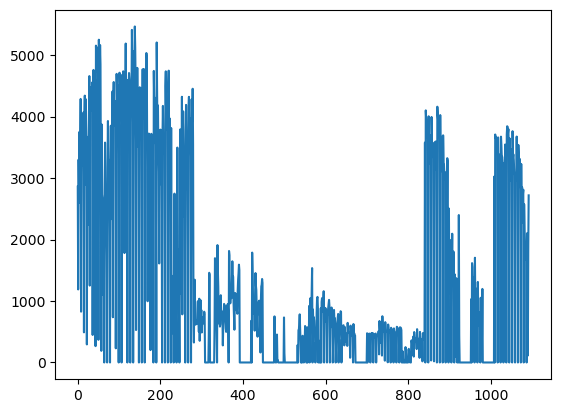

In [19]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.show()

In [20]:
submission.to_csv(os.path.join(sub_path,"baseline_submission27.csv"), index=False)

In [21]:
#11.07 12:04:06 ~ 11.08